**Name:** Omair Ansari

**Email:** ansari.omair10@gmail.com

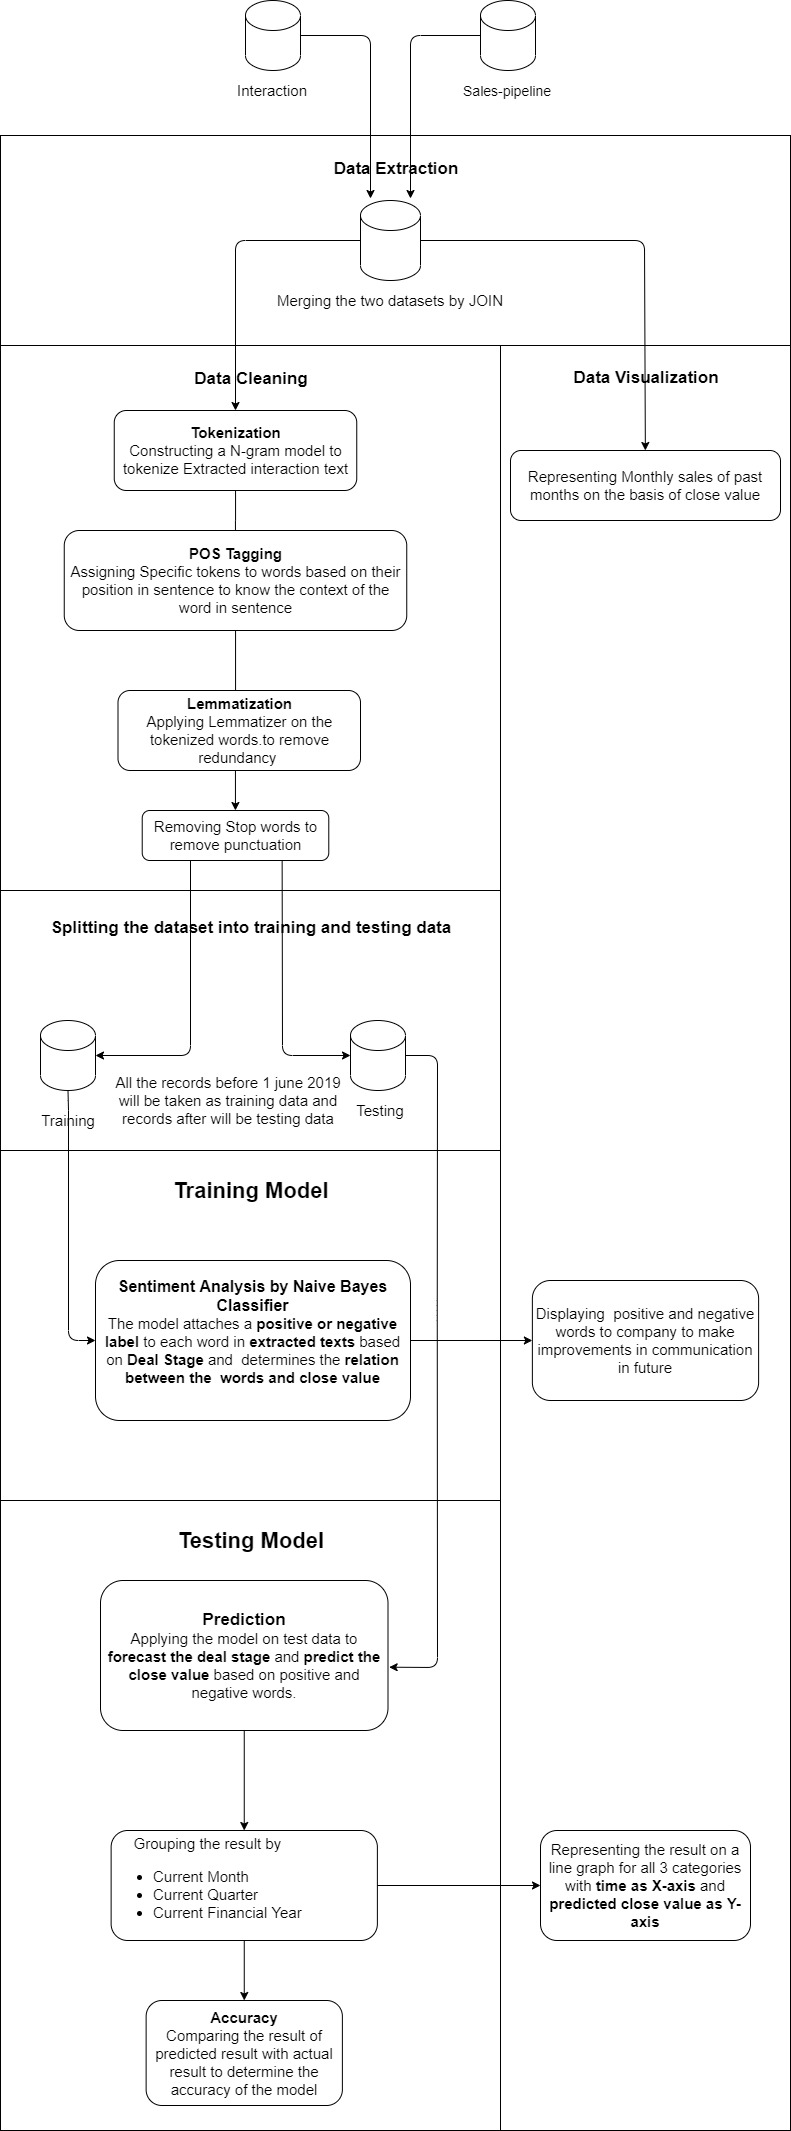

# **Data Extraction**

**Importing Libaries and packages**

In [532]:
pip install scikit-plot

In [533]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer,ToktokTokenizer
import re
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
from sklearn.naive_bayes import MultinomialNB
from string import punctuation
from nltk.stem import WordNetLemmatizer

In [534]:
pip install nltk==3.3

In [535]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


**Reading the data**

In [536]:
sales=pd.read_excel("/content/gdrive/My Drive/sales-pipeline.xlsx")

In [537]:
interaction=pd.read_excel("/content/gdrive/My Drive/interactions.xlsx")

In [538]:
sales.head()

,Account,Opportunity_ID,Sales_Agent,SalesAgentEmailID,ContactEmailID,Deal_Stage,Product,Close_Value,Created Date,Close Date,DateDiff
0,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141
1,Finjob,YFS5KLJJ,Rosalina Dieter,rosalina@piedpiper.com,belinda@finjob.com,Won,MG Special,45,2016-01-04,2016-11-02,303
2,Kinnamplus,N0ONCYVZ,Donn Cantrell,donn@piedpiper.com,monte@kinnamplus.com,Lost,MG Special,1054,2016-01-06,2016-12-07,336
3,Genco Pura Olive Oil Company,IBEUTCSW,James Ascencio,james@piedpiper.com,karole@gencopuraoliveoilcompany.com,In Progress,MG Advanced,1054,2016-01-06,2016-09-11,249
4,Initech,G8AO5FA2,Wilburn Farren,wilburn@piedpiper.com,alejandro@initech.com,Lost,MG Advanced,517,2016-01-06,2016-09-18,256


In [539]:
interaction.head()

,interactionID,fromEmailId,toEmailId,InteractionDate,InteractionType(Call/Email/SMS),Extracted Interaction Text
0,8842411,gladys@piedpiper.com,kristle@dontechi.com,2016-01-04,Call,I thoroughly enjoyed your presentation yesterd...
1,8015509,donn@piedpiper.com,orpha@umbrellacorporation.com,2016-01-04,Call,speaking with you and your staff will be a tre...
2,5976842,kary@piedpiper.com,claribel@goodsilron.com,2016-01-04,Email,"However, I am unable to join because of my fam..."
3,1471794,boris@piedpiper.com,gordon@scotfind.com,2016-01-04,Call,We are extremely sorry to inform you that we h...
4,4330320,darcel@piedpiper.com,benny@treequote.com,2016-01-04,Call,I don't think it's possible for me to meet you


In [540]:
interaction.dtypes

interactionID                               int64
fromEmailId                                object
toEmailId                                  object
InteractionDate                    datetime64[ns]
InteractionType(Call/Email/SMS)            object
Extracted Interaction Text                 object
dtype: object

**Renaming column names**

In [541]:
interaction.rename(columns = {'fromEmailId':'SalesAgentEmailID'}, inplace = True) 
interaction.rename(columns = {'toEmailId':'ContactEmailID'}, inplace = True) 

Merging the two datasets on SalesAgentEmailID and ContactEmailID

In [542]:
df= pd.merge(sales,interaction, on=['SalesAgentEmailID','ContactEmailID'],how='left')

In [543]:
df.head()

,Account,Opportunity_ID,Sales_Agent,SalesAgentEmailID,ContactEmailID,Deal_Stage,Product,Close_Value,Created Date,Close Date,DateDiff,interactionID,InteractionDate,InteractionType(Call/Email/SMS),Extracted Interaction Text
0,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141,3357865,2016-01-15,Call,We are writing from GHF regarding the previous...
1,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141,4494907,2016-01-17,Email,I had asked you to send the progress on the pr...
2,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141,1661247,2016-01-20,Call,"I wish to commend your receptionist, Jany Dan,..."
3,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141,7521235,2016-01-30,Call,I need to cancel the appointment I made to you...
4,Konex,3KR50X38,Corliss Cosme,corliss@piedpiper.com,delila@konex.com,Won,GTX Plus Basic,1255,2016-01-04,2016-05-24,141,7856100,2016-01-30,Email,Congratulations! Your hard work has paid off! ...


# **Data Analysing**

**Check Proportion Target Class Variable**

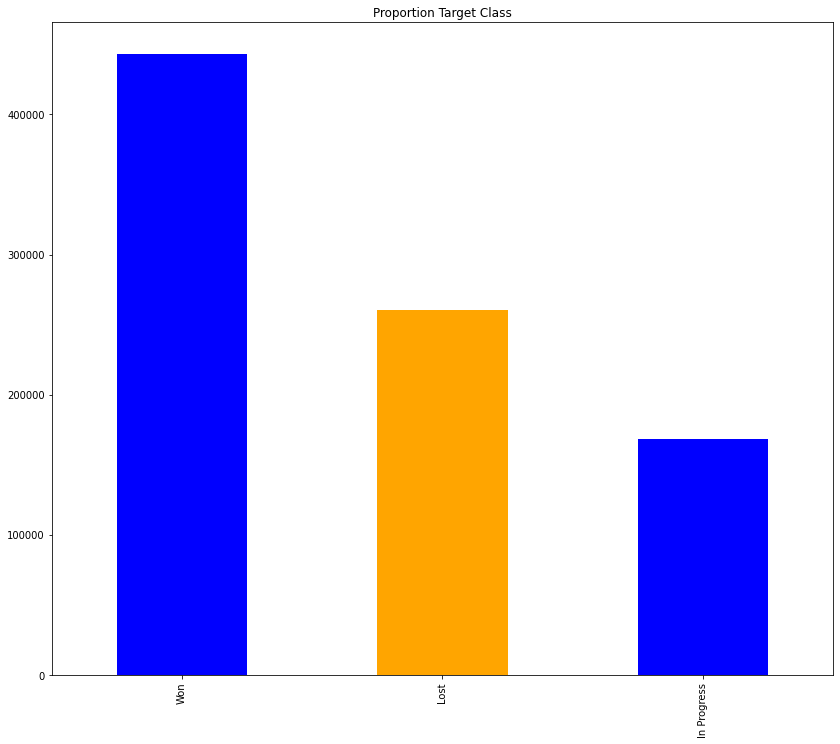

In [544]:
count_class=pd.value_counts(df["Deal_Stage"], sort= True)
count_class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Proportion Target Class')
plt.show()

In [545]:
df.Deal_Stage.value_counts()

Won            443478
Lost           260618
In Progress    168068
Name: Deal_Stage, dtype: int64

As you can see dataset has imbalanced classes therefore we oversample the minority class

In [546]:
df_majority = df[df.Deal_Stage=='Won']
df_minority = df[df.Deal_Stage=='Lost']
 
# Upsample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=443478,    # to match majority class
                                 random_state=123) # reproducible results
 
# Combine majority class with upsampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
# Display new class counts
df_upsampled.Deal_Stage.value_counts()

Lost    443478
Won     443478
Name: Deal_Stage, dtype: int64

In [547]:
df_upsampled = df_upsampled.reset_index(drop=True)

# **Data Cleaning**

In [548]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [549]:
tokenizer=ToktokTokenizer()
stopword_list=nltk.corpus.stopwords.words('english')

In [550]:
main_text = df_upsampled['Extracted Interaction Text']
target = df_upsampled['Deal_Stage']

print(len(main_text))
print(len(target))

886956
886956


In [551]:
main_text

0         We are writing from GHF regarding the previous...
1         I had asked you to send the progress on the pr...
2         I wish to commend your receptionist, Jany Dan,...
3         I need to cancel the appointment I made to you...
4         Congratulations! Your hard work has paid off! ...
                                ...                        
886951    Our congratulations on your sales success for ...
886952    I am pleased to accept your generous offer of ...
886953    This letter is to notify you of my intent to r...
886954    I regret that I must cancel our appointment to...
886955          You have a promising future in the company.
Name: Extracted Interaction Text, Length: 886956, dtype: object

## **Expanding Contraction**

In [552]:
contractions_dict = {     
"ain't": "am not",
"aren't": "are not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had",
"he'd've": "he would have",
"he'll": "he will",
"he'll've": "he will have",
"he's": "he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how is",
"I'd": "I had",
"I'd've": "I would have",
"I'll": "I will",
"I'll've": "I will have",
"I'm": "I am",
"I've": "I have",
"isn't": "is not",
"it'd": "it had",
"it'd've": "it would have",
"it'll": "it will",
"it'll've": "iit will have",
"it's": "it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had",
"she'd've": "she would have",
"she'll": "she will",
"she'll've": "she will have",
"she's": "she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so is",
"that'd": "that had",
"that'd've": "that would have",
"that's": "that is",
"there'd": "there had",
"there'd've": "there would have",
"there's": "there is",
"they'd": "they had",
"they'd've": "they would have",
"they'll": "they will",
"they'll've": "they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what will",
"what'll've": "what will have",
"what're": "what are",
"what's": "what is",
"what've": "what have",
"when's": "when is",
"when've": "when have",
"where'd": "where did",
"where's": "where is",
"where've": "where have",
"who'll": "who will",
"who'll've": "who will have",
"who's": "who is",
"who've": "who have",
"why's": "why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had",
"you'd've": "you would have",
"you'll": "you will",
"you'll've": "you will have",
"you're": "you are",
"you've": "you have"
}

In [553]:
import re
def expand_contractions(text, contractions_dict):
    contractions_pattern = re.compile('({})'.format('|'.join(contractions_dict.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contractions_dict.get(match) \
            if contractions_dict.get(match) \
            else contractions_dict.get(match.lower())
        expanded_contraction = expanded_contraction
        return expanded_contraction

    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text
def cons(text):
    text=expand_contractions(text,contractions_dict)
    return text

main_text = main_text.apply(cons)

In [554]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

## **To lowercase**

In [555]:
def to_lower(text):
    return ' '.join([w.lower() for w in word_tokenize(text)])

main_text = main_text.apply(to_lower)

## **Remove Special Character and Punctuation**

In [556]:
from string import punctuation
def remove_special_characters(text, remove_digits=True):
    pattern=r'[^a-zA-z0-9\s]'
    text=re.sub(pattern,'',text)
    return text
def strip_punctuation(s):
    return ''.join(c for c in s if c not in punctuation)

main_text = main_text.apply(remove_special_characters)
main_text = main_text.apply(strip_punctuation)

## **Replace Elongated Words**

In [557]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [558]:
from nltk.corpus import wordnet

def replaceElongated(word):
    repeat_regexp = re.compile(r'(\w*)(\w)\2(\w*)')
    repl = r'\1\2\3'
    if wordnet.synsets(word):
        return word
    repl_word = repeat_regexp.sub(repl, word)
    if repl_word != word:      
        return replaceElongated(repl_word)
    else:       
        return repl_word
main_text = main_text.apply(replaceElongated)

## **Tokenization**

In [559]:
tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')

main_text = main_text.apply(lambda x: tokenizer.tokenize(x))

## **Removing Stopwords**

In [560]:
def remove_stopwords(text):
    words = [w for w in text if w not in stopword_list]
    return words

main_text = main_text.apply(lambda x : remove_stopwords(x))

## **Stemming**

In [561]:
from nltk.stem import SnowballStemmer

snowball_stemmer = SnowballStemmer('english')

def stem_update(text_list):
    text_list_new = []
    for word in text_list:
        word = snowball_stemmer.stem(word)
        text_list_new.append(word)
    return text_list_new
main_text = main_text.apply(stem_update)

**Drop Numbers**

In [562]:
def drop_numbers(list_text):
    list_text_new = []
    for i in list_text:
        if not re.search('\d', i):
            list_text_new.append(i)
    return ' '.join(list_text_new)
main_text = main_text.apply(drop_numbers)

In [563]:
main_text

0         write ghf regard previous discus busin propos ...
1         ask send progr project end last wek stil got s...
2         wish comend receptionist jani dan way handl pr...
3                            ned cancel apoint made januari
4         congratul hard work paid carefuli review perfo...
                                ...                        
886951    congratul sale suce last quarter know achiev c...
886952    pleas acept generous ofer engin posit bmn corp...
886953    leter notifi intent resign posit asist persone...
886954    regret must cancel apoint discus athlet cloth ...
886955                                 promis futur compani
Name: Extracted Interaction Text, Length: 886956, dtype: object

In [564]:
df1 = pd.concat([main_text,target],axis=1)

In [565]:
df1.rename(columns = {'Extracted Interaction Text':'interaction'}, inplace = True) 

In [566]:
df1.head()

,interaction,Deal_Stage
0,write ghf regard previous discus busin propos ...,Won
1,ask send progr project end last wek stil got s...,Won
2,wish comend receptionist jani dan way handl pr...,Won
3,ned cancel apoint made januari,Won
4,congratul hard work paid carefuli review perfo...,Won


# **Most Common Words where Deal Stage was won**

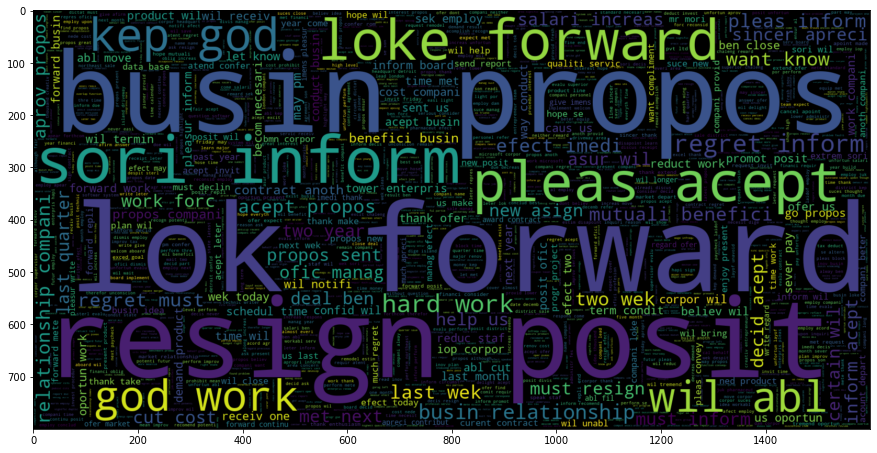

In [567]:
from wordcloud import WordCloud
plt.figure(figsize = (15,15)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df1[df1.Deal_Stage == 'Won'].interaction))
plt.imshow(wc , interpolation = 'bilinear')

# **Most Common Words where Deal Stage was lost**

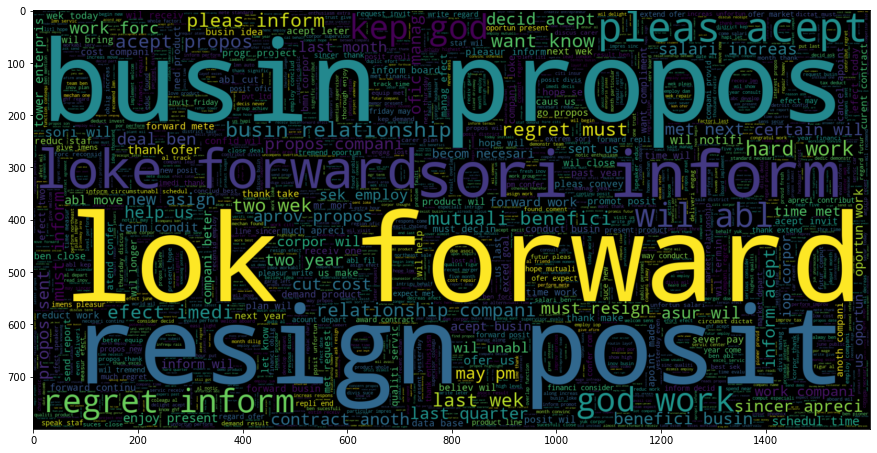

In [568]:
from wordcloud import WordCloud
plt.figure(figsize = (15,15)) 
wc = WordCloud(width = 1600 , height = 800 , max_words = 3000).generate(" ".join(df1[df1.Deal_Stage == 'Lost'].interaction))
plt.imshow(wc , interpolation = 'bilinear')

# **Modelling using Multinomial Naive Bayes**

## **Split the data and count the vectorize in each words**

In [569]:
cv=CountVectorizer()
from sklearn.model_selection import train_test_split
cv = CountVectorizer(ngram_range=(1,1),
                           stop_words='english')
train_data,test_data = train_test_split(df1,train_size=0.5,random_state=0)

X_train = cv.fit_transform(train_data['interaction'])
y_train = train_data['Deal_Stage']
X_test = cv.transform(test_data['interaction'])
y_test = test_data['Deal_Stage']

In [570]:
test_data

,interaction,Deal_Stage
294028,read inov plan improv tax deduct invest proced...,Won
520918,apreci interest english languag schol supli la...,Lost
182435,convinc report,Won
527787,unfortun manufactur discontinu item,Lost
539351,sure manag wil agr give propos shot,Lost
...,...,...
230134,must ben misunderstand alreadi contract anoth ...,Won
680600,promis futur compani,Lost
271443,regret must inform posit magnus market depart ...,Won
516630,se cute edg technolog empow increas product ac...,Lost


In [571]:
print(X_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


## **Training the model**

In [572]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

# **Evaluation**

In [573]:
nb_predict=nb.predict(X_test)

In [574]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,recall_score,precision_score
nb_report = accuracy_score(y_test,nb_predict)
print('Accuracy:',nb_report)

Accuracy: 0.5014995106859866


In [575]:
nb_report1 = recall_score(y_test,nb_predict,pos_label='Won',average='binary')
print('Recall:',nb_report1)

Recall: 0.50119217715437


In [576]:
nb_report2 = precision_score(y_test,nb_predict,pos_label='Won',average='binary')
print('Precision:',nb_report2)

Precision: 0.5017802105567163


From the result above, we get the value of **Accuracy** around in 0.50 which means that we have 50% level of confidence that the model was accurate.

And we have the **Recall** value around in 0.954 which means that we have 50% "Won" deal stage which predicted correctly.

And we have the **Precision** value around in 0.63 which means that we have 50% "Lost" deal stage from predicted positive value which actually positive.

# **Model for predicting close value by ridge regression**

In [577]:
value=df['Close_Value']

In [578]:
df2 = pd.concat([main_text,value,target],axis=1)
df2=df2.dropna()
df2

,Extracted Interaction Text,Close_Value,Deal_Stage
0,write ghf regard previous discus busin propos ...,1255.0,Won
1,ask send progr project end last wek stil got s...,1255.0,Won
2,wish comend receptionist jani dan way handl pr...,1255.0,Won
3,ned cancel apoint made januari,1255.0,Won
4,congratul hard work paid carefuli review perfo...,1255.0,Won
...,...,...,...
872159,sori wil unabl help individu tax return past y...,1014.0,Lost
872160,unfortun abl move hose time would necesit dige...,1014.0,Lost
872161,pleas inform board aprov excel propos far best...,1014.0,Lost
872162,asur wil face problem,1014.0,Lost


In [579]:
cv1=CountVectorizer()
from sklearn.model_selection import train_test_split

train_data,test_data = train_test_split(df2,train_size=0.8,random_state=0)

X_train = cv1.fit_transform(train_data['Extracted Interaction Text'])
y_train = train_data['Close_Value']
X_test = cv1.transform(test_data['Extracted Interaction Text'])
y_test = test_data['Close_Value']

In [580]:
print(X_train.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


## **Ridge Regression**

In [581]:
from sklearn.linear_model import Ridge
ridge=Ridge()
model=ridge.fit(X_train,y_train)

In [582]:
X_test

<174433x1040 sparse matrix of type '<class 'numpy.int64'>'
	with 2771279 stored elements in Compressed Sparse Row format>

In [583]:
y_test_pred=model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


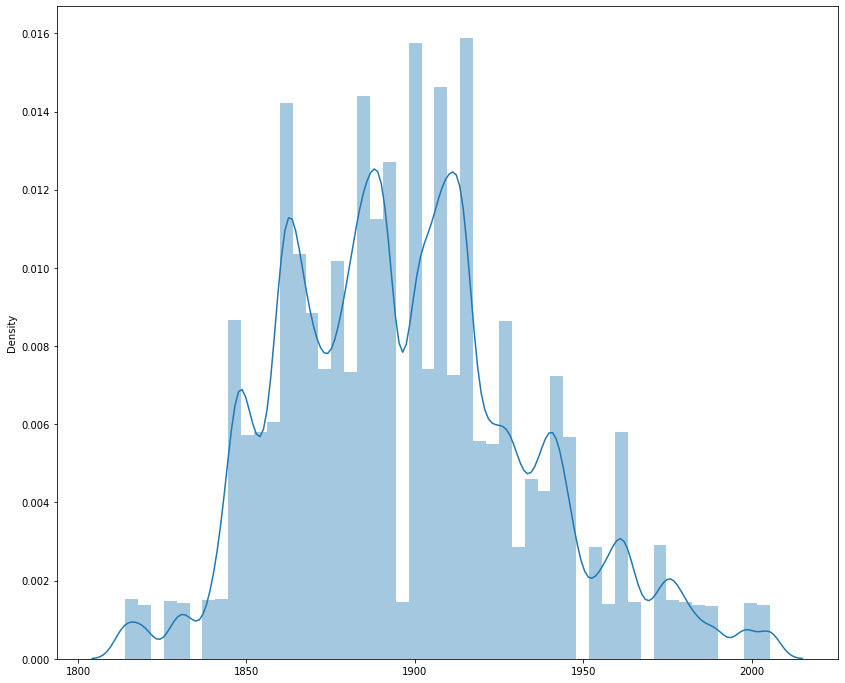

In [584]:
import seaborn as sns
sns.distplot(y_test_pred)

# **Current Month Forecast (June 2019)**

In [598]:
mask = (interaction['InteractionDate'] > '2019-06-1') & (interaction['InteractionDate'] <'2019-07-01')
monthly_df=interaction.loc[mask]
test1=monthly_df["Extracted Interaction Text"]

In [599]:
test1 = test1.apply(cons)
test1= test1.apply(remove_special_characters)
test1 = test1.apply(strip_punctuation)
test1 = test1.apply(replaceElongated)
test1 = test1.apply(to_lower)
test1= test1.apply(lambda x: tokenizer.tokenize(x))
test1 = test1.apply(lambda x : remove_stopwords(x))
test1 = test1.apply(stem_update)
test1 = test1.apply(drop_numbers)
month = pd.DataFrame(columns = ['interaction'])
month["interaction"]=test1
month_test = cv.transform(month['interaction'])
month["Deal_Stage"]=nb.predict(month_test)
month_test = cv1.transform(month['interaction'])
month['Close_Value'] =model.predict(month_test)

<Figure size 800x720 with 0 Axes>

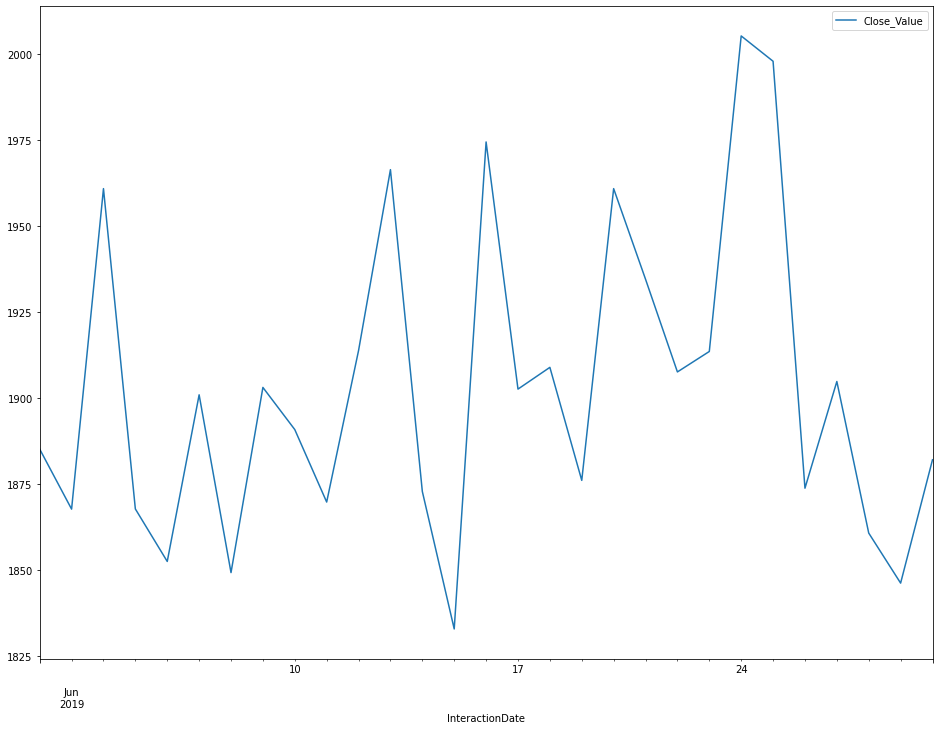

In [601]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
month.loc[month.Deal_Stage=='Lost','Close_Value']=-month['Close_Value']
figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')
month_graph = pd.DataFrame()
month_graph['Close_Value'] = month["Close_Value"]
month_graph["InteractionDate"]=monthly_df["InteractionDate"]
month_graph['Total'] = month_graph.groupby(['InteractionDate'])['Close_Value'].transform('sum')
month_graph = month_graph.drop_duplicates(subset='InteractionDate', keep='first')
plt.rcParams["figure.figsize"] = [16,12]

month_graph.plot('InteractionDate','Close_Value')
plt.show()

# **Current Quarter (April 2019 - June 2019)**

In [588]:
mask = (interaction['InteractionDate'] > '2019-04-1') & (interaction['InteractionDate'] <'2019-07-01')
monthly_df=interaction.loc[mask]
test1=monthly_df["Extracted Interaction Text"]

In [589]:
test1 = test1.apply(cons)
test1= test1.apply(remove_special_characters)
test1 = test1.apply(strip_punctuation)
test1 = test1.apply(replaceElongated)
test1 = test1.apply(to_lower)
test1= test1.apply(lambda x: tokenizer.tokenize(x))
test1 = test1.apply(lambda x : remove_stopwords(x))
test1 = test1.apply(stem_update)
test1 = test1.apply(drop_numbers)
month = pd.DataFrame(columns = ['interaction'])
month["interaction"]=test1
month_test = cv.transform(month['interaction'])
month["Deal_Stage"]=nb.predict(month_test)
month_test = cv1.transform(month['interaction'])
month['Close_Value'] =model.predict(month_test)

<Figure size 800x720 with 0 Axes>

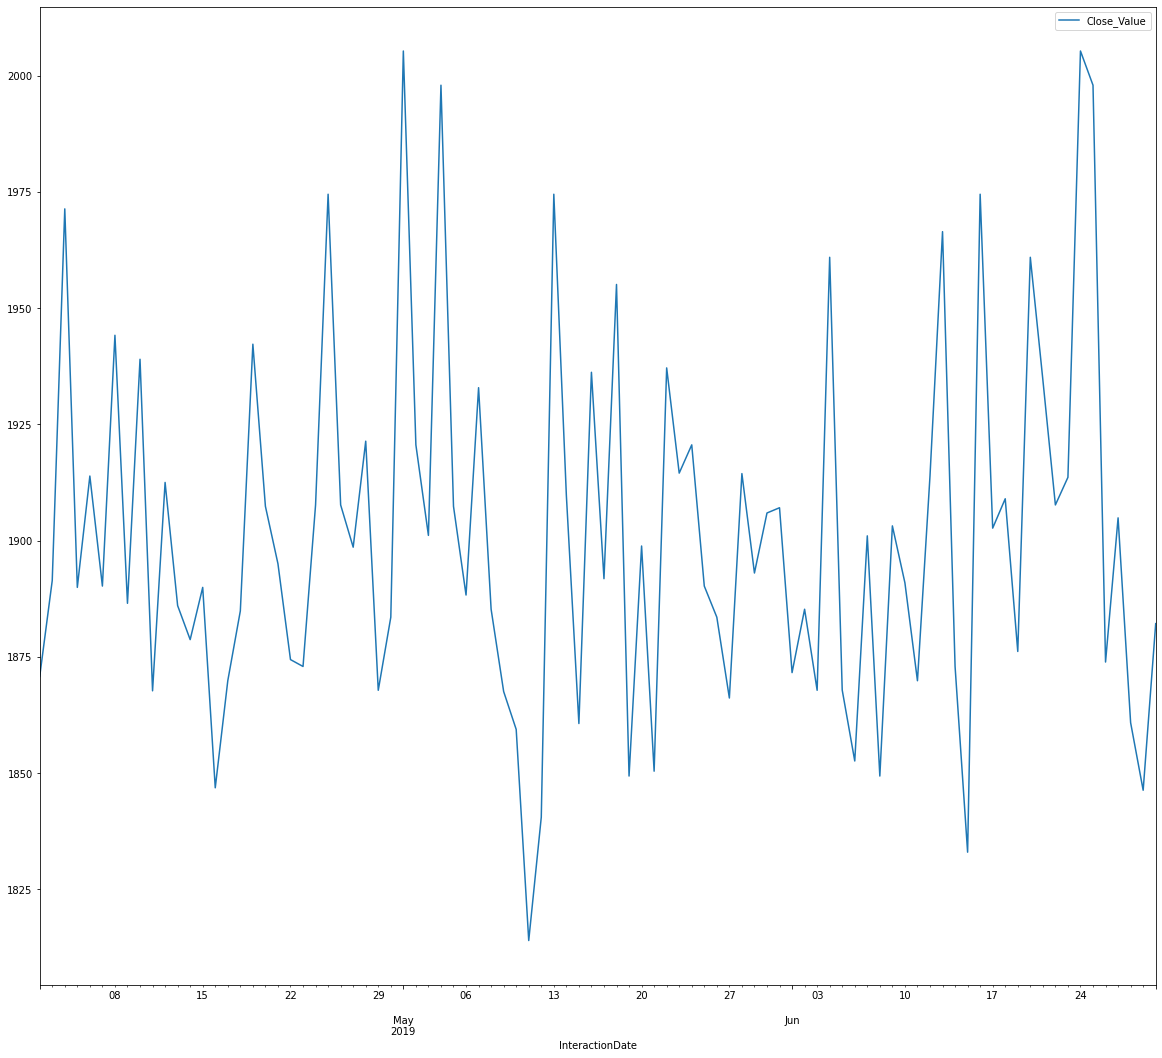

In [597]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
month.loc[month.Deal_Stage=='Lost','Close_Value']=-month['Close_Value']
figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')
month_graph = pd.DataFrame()
month_graph['Close_Value'] = month["Close_Value"]
month_graph["InteractionDate"]=monthly_df["InteractionDate"]
month_graph['Total'] = month_graph.groupby(['InteractionDate'])['Close_Value'].transform('sum')
month_graph = month_graph.drop_duplicates(subset='InteractionDate', keep='first')
plt.rcParams["figure.figsize"] = [20,18]

month_graph.plot('InteractionDate','Close_Value')
plt.show()

# **Current Year Forecast(2019)**

In [602]:
mask = (interaction['InteractionDate'] > '2019-01-01') & (interaction['InteractionDate'] <'2020-01-01')
monthly_df=interaction.loc[mask]
test1=monthly_df["Extracted Interaction Text"]

In [603]:
test1 = test1.apply(cons)
test1= test1.apply(remove_special_characters)
test1 = test1.apply(strip_punctuation)
test1 = test1.apply(replaceElongated)
test1 = test1.apply(to_lower)
test1= test1.apply(lambda x: tokenizer.tokenize(x))
test1 = test1.apply(lambda x : remove_stopwords(x))
test1 = test1.apply(stem_update)
test1 = test1.apply(drop_numbers)
month = pd.DataFrame(columns = ['interaction'])
month["interaction"]=test1
month_test = cv.transform(month['interaction'])
month["Deal_Stage"]=nb.predict(month_test)
month_test = cv1.transform(month['interaction'])
month['Close_Value'] =model.predict(month_test)

<Figure size 800x720 with 0 Axes>

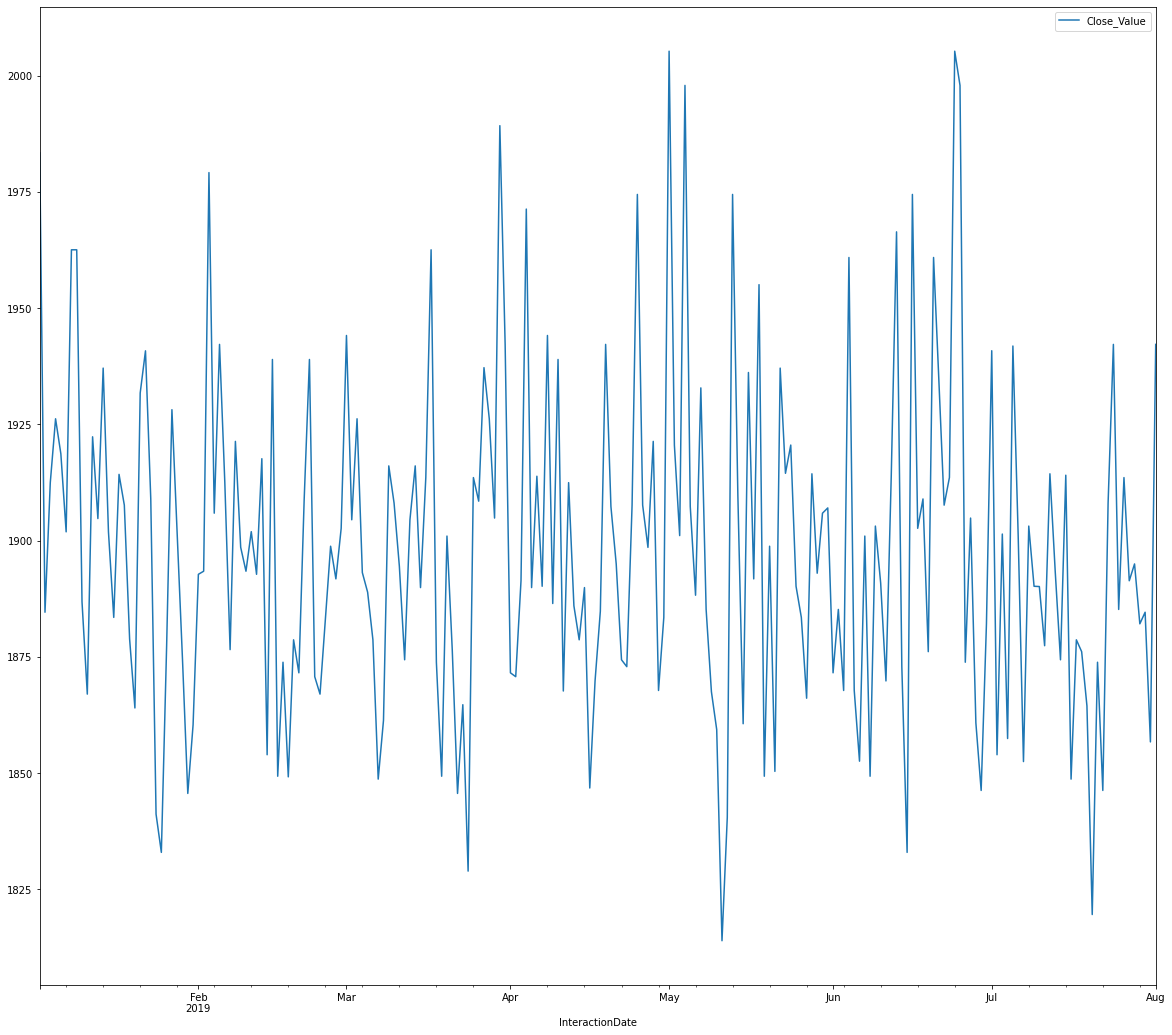

In [607]:
from matplotlib.pyplot import figure
from matplotlib import pyplot
month.loc[month.Deal_Stage=='Lost','Close_Value']=-month['Close_Value']
figure(num=None, figsize=(10, 9), dpi=80, facecolor='w', edgecolor='k')
month_graph = pd.DataFrame()
month_graph['Close_Value'] = month["Close_Value"]
month_graph["InteractionDate"]=monthly_df["InteractionDate"]
month_graph['Total'] = month_graph.groupby(['InteractionDate'])['Close_Value'].transform('sum')
month_graph = month_graph.drop_duplicates(subset='InteractionDate', keep='first')
plt.rcParams["figure.figsize"] = [20,18]

month_graph.plot('InteractionDate','Close_Value')
plt.show()